In [ ]:
import time
import datetime
from binance import Client # pip install python-binance
import pandas as pd
import os

In [ ]:
download = False
if download:
    %pip install python-binance
    %pip install pandas
    %pip install pyarrow

In [ ]:
dir = 'data/prices'
timeframes = ['1min', '5min', '15min', '1h', '4h', '1d', '1w']

from data import CryptoData

asset = 'BTC'
interval = '1d'
start_dt = datetime.date(2018, 2, 1) 
last_dt = datetime.date(2024, 2, 12)

data_downloader = CryptoData(asset, interval, start_dt, last_dt)
data_downloader.get_crypto_data()

## Get Crypto Greed & Fear Index

In [ ]:
from data import CryptoCFGIData

# Usage:
data_downloader = CryptoCFGIData()
data = data_downloader.download_data()

## Google News

In [26]:
%load_ext autoreload
%autoreload 1

In [27]:
%aimport data
from data import CryptoData, CryptoCFGIData, BTCNews

%aimport news_analysis
import news_analysis as nws
import pandas as pd
import numpy as np

/home/anshu/miniconda3/envs/crypto/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
def check_if_text_is_valid(text):
    keywords = ['bitcoin', 'btc', 'cryptocurrency', 'crypto']
    if pd.isnull(text) or text == '':
        return False
    elif len(text) < 500 and not any(word in text.lower() for word in keywords):
        return False
    return True

def load_crypto_data(file_path):
    cryptonews = pd.read_csv(file_path)
    cryptonews['Date'] = pd.to_datetime(cryptonews['Date'])
    cryptonews = cryptonews.sort_values(by='Date', ascending=True)
    cryptonews = cryptonews.reset_index(drop=True)

    if 'count' not in cryptonews.columns:
        # Count the number of news articles per day
        cryptonews['count'] = -1
        cryptonews['count'] = cryptonews['count'].groupby(cryptonews.Date.dt.date).transform(np.size)
        
    if 'Text' in cryptonews.columns:
        # Check if the text is valid by checking the length and the presence of keywords    
        cryptonews['Valid_Text'] = cryptonews['Text'].apply(check_if_text_is_valid)
    
    return cryptonews


In [34]:
file_path = "data/news/btc_news.csv"
cryptonews = load_crypto_data(file_path)

In [ ]:
# # prices.join(cfgi, on='Date', how='inner')

# merged_df = prices.merge(cfgi, on='Date', how='inner')
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax = plt.subplots(figsize=(15, 7))
# merged_df['Close_pct'] = merged_df['Close'].pct_change()
# sns.lineplot(data=merged_df, x='Date', y='Close_pct', ax=ax)
# ax2 = ax.twinx()
# sns.lineplot(data=merged_df, x='Date', y='Value', ax=ax2, color='r')

## Part 3

Directory Structure
- btc_news contains the data got from Google Search (Title, URL, Date, Source)
- btc_news_text contains the above + the actual text of the article 
- btc_news_summary1,2,3 contains only the summaries for all the articles 
    - Part 1 contains 0-1219 (exclusive)
    - Part 2 contains 1219-10000 (exclusive)
    - Part 3 contains 10000-end
- summary is the final combined file with all the summaries

Note: This was done as the data was split into 3 parts to leverage the use of GPU across different platforms (Kaggle, Google Colab) for faster summarization 

In [141]:
file_path = 'data/news/btc_news_text.csv'
news = load_crypto_data(file_path)
news.head()

,Title,URL,Date,Source,Text,count,Valid_Text
0,Some clinics allow patients to pay in bitcoin ...,https://news.google.com/rss/articles/CBMiRmh0d...,2018-02-01 08:00:00,STAT,Some clinics allow patients to pay in bitcoin ...,19,True
1,Why is Bitcoin’s price down to two-month lows?...,https://news.google.com/rss/articles/CBMiPWh0d...,2018-02-01 08:00:00,TechCrunch,Crypto investors are seeing red this week. Bit...,19,True
2,A Bitcoin Conference Rented a Miami Strip Club...,https://news.google.com/rss/articles/CBMicGh0d...,2018-02-01 08:00:00,Bloomberg,The North American Bitcoin Conference wrapped ...,19,True
3,"Peter Thiel Says, 'Crypto Is Libertarian, A.I....",https://news.google.com/rss/articles/CBMiO2h0d...,2018-02-01 08:00:00,Inc.,NaN,19,False
4,Bitcoin's January fall wipes off $44bn in valu...,https://news.google.com/rss/articles/CBMiYGh0d...,2018-02-01 08:00:00,The Guardian,Bitcoin plummeted in value by more than $44bn ...,19,True


In [142]:
### Combine the 3 summaries data into one dataframe ####
import pandas as pd

p1 = pd.read_csv('data/news/btc_news_summary1.csv')
p1 = p1.iloc[:1219]
p2 = pd.read_csv('data/news/btc_news_summaryPart2.csv')
p3 = pd.read_csv('data/news/btc_news_summary3.csv')


print(p1.shape, p2.shape, p3.shape)
print(f'Total rows: {p1.shape[0] + p2.shape[0] + p3.shape[0]}')
assert p1.shape[0] + p2.shape[0] + p3.shape[0] == news.shape[0]

summaries_comb = pd.concat([p1, p2, p3], axis=0)
summaries_comb = summaries_comb.reset_index(drop=True)
summaries_comb.to_csv('data/news/summary.csv', index=False)

(1219, 1) (8781, 1) (25374, 1)
Total rows: 35374


In [143]:
# Dropping the Text column as we don't need it anymore 
# Since we have the summaries 
# news.drop('Text', axis=1, inplace=True)
news['Summary'] = summaries_comb['Summary']
print(f"The dataset has {news.Summary.isnull().sum()} missing values")

The dataset has 9055 missing values


These missing values exist because the articles couldn't be accessed through Python as the websites had some kind of blocker enabled on them to prevent scraping. It is not wise to drop all these rows as they still contain a lot of valuable information. 

Alternate Solution: To use the title of the news article as its summary. While this approach is not ideal, it is better than dropping the rows entirely. In addition, the title of the news article should still contain sufficient information for the subsequent models to use

In [144]:
news.Summary = np.where(news.Summary.isnull(), news.Title, news.Summary)
print(news.Summary.isna().sum())

idxs_drop = news[news.Summary.str.len() > 700].index
news.loc[idxs_drop, 'Summary'] = news.loc[idxs_drop, 'Title']

# news.to_csv('data/news/data4sentiment.csv', index=False)

0


In [153]:
sa_scores = pd.read_csv('data/news/news_sa.csv')

news['Sentiment_Label'] = sa_scores['Sentiment_Label']
news['Sentiment_Score'] = sa_scores['Sentiment_Score']
news.to_parquet('data/news/final.parquet', index=False)

In [21]:
### Load the final dataset ###
import pandas as pd
news = pd.read_parquet('data/news/final.parquet')
news['Date'] = pd.to_datetime(news['Date'])

sentiment_dict = {'negative': -1, 'neutral': 0, 'positive': 1}
news['Sentiment_Label'] = news['Sentiment_Label'].map(sentiment_dict)

news.head()

,Title,URL,Date,Source,Text,count,Valid_Text,Summary,Sentiment_Label,Sentiment_Score
0,Some clinics allow patients to pay in bitcoin ...,https://news.google.com/rss/articles/CBMiRmh0d...,2018-02-01 08:00:00,STAT,Some clinics allow patients to pay in bitcoin ...,19,True,As the value of the digital currency bitcoin c...,1,0.507967
1,Why is Bitcoin’s price down to two-month lows?...,https://news.google.com/rss/articles/CBMiPWh0d...,2018-02-01 08:00:00,TechCrunch,Crypto investors are seeing red this week. Bit...,19,True,"It’s been a rough week for the crypto world, a...",1,0.996861
2,A Bitcoin Conference Rented a Miami Strip Club...,https://news.google.com/rss/articles/CBMicGh0d...,2018-02-01 08:00:00,Bloomberg,The North American Bitcoin Conference wrapped ...,19,True,One of the world’s largest conferences on the ...,0,0.999861
3,"Peter Thiel Says, 'Crypto Is Libertarian, A.I....",https://news.google.com/rss/articles/CBMiO2h0d...,2018-02-01 08:00:00,Inc.,None,19,False,"Peter Thiel Says, 'Crypto Is Libertarian, A.I....",0,0.999423
4,Bitcoin's January fall wipes off $44bn in valu...,https://news.google.com/rss/articles/CBMiYGh0d...,2018-02-01 08:00:00,The Guardian,Bitcoin plummeted in value by more than $44bn ...,19,True,The price of bitcoin has continued to fall as ...,0,0.999851


-1

In [54]:
news.groupby(news.Date.dt.date)['Sentiment_Label'].mean().reset_index()

,Date,Sentiment_Label
0,2018-02-01,0.105263
1,2018-02-02,-0.259259
2,2018-02-03,-0.400000
3,2018-02-04,-0.250000
4,2018-02-05,-0.444444
...,...,...
2201,2024-02-13,0.062500
2202,2024-02-14,0.210526
2203,2024-02-15,0.555556
2204,2024-02-16,0.090909


In [81]:
# Calculate the mean sentiment score per day
agg_daily_sentiment = news.groupby(news.Date.dt.date)['Sentiment_Label'].mean().reset_index()

# Calculate the percentage of the positive, negative and neutral news articles per day
news_percent = news.groupby(news.Date.dt.date)['Sentiment_Label'].apply(lambda x: x.value_counts()).unstack().reset_index()
news_percent.fillna(0, inplace=True)
news_percent.columns = ['Date', 'Negative', 'Neutral', 'Positive']
news_percent['Total'] = news_percent['Negative'] + news_percent['Neutral'] + news_percent['Positive']   
news_percent[['Negative', 'Neutral', 'Positive']] = news_percent[['Negative', 'Neutral', 'Positive']].div(news_percent['Total'], axis=0)

# Store it back into the main df
agg_daily_sentiment['Negative_Percent'] = news_percent['Negative']
agg_daily_sentiment['Neutral_Percent'] = news_percent['Neutral']
agg_daily_sentiment['Positive_Percent'] = news_percent['Positive']

In [82]:
agg_daily_sentiment.head()

,Date,Sentiment_Label,Negative_Percent,Neutral_Percent,Positive_Percent
0,2018-02-01,0.105263,0.157895,0.578947,0.263158
1,2018-02-02,-0.259259,0.296296,0.666667,0.037037
2,2018-02-03,-0.400000,0.600000,0.200000,0.200000
3,2018-02-04,-0.250000,0.500000,0.250000,0.250000
4,2018-02-05,-0.444444,0.518519,0.407407,0.074074


In [83]:
agg_daily_sentiment.isna().sum()    

Date                0
Sentiment_Label     0
Negative_Percent    0
Neutral_Percent     0
Positive_Percent    0
dtype: int64

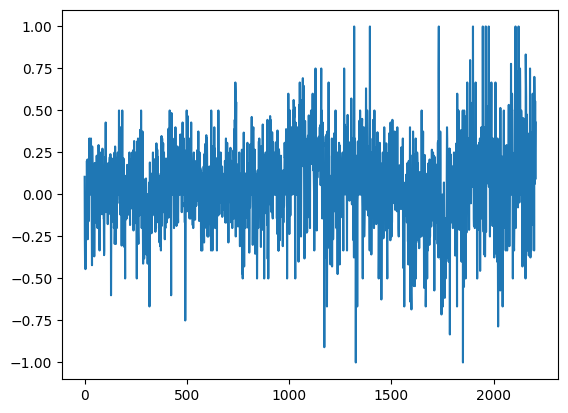

In [58]:
agg_daily_sentiment['Sentiment_Label'].plot();

In [84]:
agg_daily_sentiment.to_csv('data/news/agg_daily_sentiment.csv', header=True)

## Part 4 - Combine and create new dataset

In [115]:
import pandas as pd 
import numpy as np

# Load the data
cfgi = pd.read_csv('data/cfgi/cfgi.csv')
prices = pd.read_csv('data/prices/1d/BTCUSDT.csv')
sentiment = pd.read_csv('data/news/agg_daily_sentiment.csv')

# Rename the date column in prices dataset 
prices = prices.rename(columns={'Time': 'Date'})

# Convert the date to datetime
cfgi['Date'] = pd.to_datetime(cfgi['Date'])
prices['Date'] = pd.to_datetime(prices['Date'], format="%d-%m-%Y")
sentiment['Date'] = pd.to_datetime(sentiment['Date'])

# Merge the data
merged_df = prices.merge(cfgi, on='Date', how='left')
merged_df = merged_df.merge(sentiment, on='Date', how='left')
merged_df.drop('Unnamed: 0', axis=1, inplace=True)

# Get the entire date range to check for missing dates 
dt_range = pd.date_range(start = '2018-02-01', end = '2024-02-11', freq='D')
dt_range = pd.DataFrame(dt_range, columns=['date'])

# Merged with a left join to keep all the dates
merged_df = dt_range.merge(merged_df, left_on='date', right_on='Date', how='left')
merged_df.drop('Date', axis=1, inplace=True)
merged_df.sort_values(by='date', inplace=True)

# Fill the missing values with the previous value
# Assumption: If there is now news about crypto we assume that the news sentiment stays the same as the previous day 
# Assumption: If there is no cfgi value we assume that the value stays the same as the previous day
merged_df= merged_df.ffill()

# Save the data to a parquet file
merged_df.to_parquet('data/merged_data.parquet', index=False)